More or less a replication of [Mysteries of mode collapse by Janus](https://www.lesswrong.com/posts/t9svvNPNmFf5Qa3TA/mysteries-of-mode-collapse)

Using Pythia models of various sizes. 

Compares base models with SFT models and DPO finetuned models. 

TODO: Compare with RLHF models



## Import stuff

In [3]:
# !pip install sty

In [1]:
from transformers import GPTNeoXForCausalLM, AutoTokenizer
import torch
import numpy as np
import matplotlib.pyplot as plt
# import os
from sty import bg, fg, Style, RgbBg

torch.cuda.is_available()

True

## Get models

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu' 

In [3]:
# Let's look 410m parameter models. 
model410m_base = GPTNeoXForCausalLM.from_pretrained("EleutherAI/pythia-410m").to(device)
model410m_sft = GPTNeoXForCausalLM.from_pretrained("lomahony/pythia-410m-helpful-sft").to(device)
model410m_dpo = GPTNeoXForCausalLM.from_pretrained("lomahony/pythia-410m-helpful-dpo").to(device)

tokenizer410m = AutoTokenizer.from_pretrained("EleutherAI/pythia-410m")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
model_base = model410m_base
model_sft = model410m_sft
model_dpo = model410m_dpo

tokenizer = tokenizer410m

In [5]:
# tokenizer70m.pad_token_id:0
# tokenizer70m.eos_token_id:0
pad_token_id=tokenizer.eos_token_id

## Utilities

In [6]:
# https://github.com/feluxe/sty
def colour_text(token, probability): 
    if probability >= 0.99:
        print(bg.da_green + fg.white + token.replace("\n","\\n") + fg.rs + bg.rs, end='')
         
    elif probability >= 0.95:
        print(bg.li_green + fg.white + token.replace("\n","\\n") + fg.rs + bg.rs, end='')
         
    elif probability >= 0.9:
        print(bg.green + token.replace("\n","\\n") + bg.rs, end='')

    elif probability >= 0.8:
        # print(bg.yellow + token + bg.rs)
        bg.yellow_green = Style(RgbBg(153, 153, 0))
        print(bg.yellow_green + token.replace("\n","\\n") + bg.rs, end='')

    elif probability >= 0.5:
        # bg.orange = Style(RgbBg(255, 150, 50))
        # print(bg.orange + token + bg.rs)
        print(bg.yellow + token.replace("\n","\\n") + bg.rs, end='')

    elif probability >= 0.2:
        # print(bg.li_yellow + token + bg.rs)
        bg.orange = Style(RgbBg(255, 150, 50))
        print(bg.orange + token.replace("\n","\\n") + bg.rs, end='')
        
    elif probability >= 0.1:
        bg.da_orange = Style(RgbBg(255, 120, 0))
        print(bg.da_orange + token.replace("\n","\\n") + bg.rs, end='')
        
    elif probability >= 0.05:
        print(bg.red + fg.white + token.replace("\n","\\n") + fg.rs + bg.rs, end='')

    elif probability >= 0.01:
        print(bg.li_red + fg.white + token.replace("\n","\\n") + fg.rs + bg.rs, end='')
        
    elif probability < 0.01:
        print(bg.da_red + fg.white + token.replace("\n","\\n") + fg.rs + bg.rs, end='')
        

In [7]:
probs = [0,0.01, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.98, 0.99]
# for i in probs: 
    # colour_text("test",i)
for idx, prob in enumerate(probs[:-1]): 
    colour_text(f"[{probs[idx]},{probs[idx+1]})",prob)
colour_text(f"[{probs[-1]},1]",1)

[0,0.01)[0.01,0.05)[0.05,0.1)[0.1,0.2)[0.2,0.5)[0.5,0.8)[0.8,0.9)[0.9,0.98)[0.98,0.99)[0.99,1]

In [8]:
def plot_probability_spectrum(model, text, tokenizer, temperature=1.0, print_output_plain=False): 
    inputs = tokenizer(text, return_tensors="pt").to(device) # , temperature
    tokens = model.generate(**inputs, temperature=temperature, max_new_tokens=100, output_scores=True, renormalize_logits=True, return_dict_in_generate=True) # shape input plus generated
    out = tokenizer.decode(tokens['sequences'][0]) 
    if print_output_plain: 
        print(out)
    input_length = inputs.input_ids.shape[1] # shape num tokens generated
    generated_tokens = tokens.sequences[:, input_length:]
    transition_scores = model.compute_transition_scores(tokens.sequences, tokens.scores, normalize_logits=True)
    
    for idx, tok in enumerate(tokens['sequences'][:, input_length:][0]): 
        colour_text(f"{tokenizer.decode(tok)}", np.exp(transition_scores[0][idx].cpu()))

In [9]:
torch.set_printoptions(precision=4)

In [10]:
torch.set_printoptions(precision=4)
def output_probs(model, text, tokenizer, n=50):
    inputs = tokenizer(text, return_tensors="pt").to(device)
    tokens = model.generate(**inputs, max_new_tokens=1, output_scores=True, 
                            renormalize_logits=True, return_dict_in_generate=True) # shape input plus generated
    arr = np.exp(tokens.scores[0].cpu()[0])
    toks = list(np.asarray(arr).argsort()[-n:][-n:][::-1])
    # np.exp(tokens.scores[tok_id].cpu()[0])[toks]) #€€€ changed to 0
    tok_probs = np.exp(tokens.scores[0].cpu()[0])[toks]
    # print(toks)
    # print(tokenizer.decode(toks))
    # print(tok_probs)
    for idx, tok in enumerate(toks): 
        # print(f"{tokenizer.decode(tok)}", tok_probs[idx])
        colour_text(f"{tokenizer.decode(tok)}", tok_probs[idx])
        print(f" - {tok_probs[idx]:.4f}") 
    return toks, tok_probs

In [11]:
# stop

## Selected model output certainties visualised

Visualise certainty of next token predictions similar to OpenAI playground probability spectrum visualisation. 

Visualise probability of random numbers. Rephrased many times. 

### Probability spectrum Illustrations

#### "are bugs real?"

In [12]:
text = "are bugs real?"

In [13]:
plot_probability_spectrum(model_base, text, tokenizer, temperature = 1)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


\n<james_w> I think it's a bug in the way the package is packaged\n<james_w> I think it's a bug in the way the package is packaged\n<james_w> I think it's a bug in the way the package is packaged\n<james_w> I think it's a bug in the way the package is packaged\n<james_w> I think it's a bug in the way the package is packaged

In [14]:
text = "Human: are bugs real? Assistant:"

In [15]:
plot_probability_spectrum(model_base, text, tokenizer, temperature = 1)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


 yes.\n\nI'm not sure if this is a bug or not, but I'm not sure if it's a good idea to use the "no" button when you're not sure if a bug is real or not.\n\nA:\n\nI think it's a bug.\nThe button is not supposed to be used when you're not sure if a bug is real or not.\n\nA:\n\nI think it's a bug.\nThe button is not

In [16]:
plot_probability_spectrum(model_sft, text, tokenizer, temperature = 1)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


 Yes, bugs are real.\nHuman: What are some good ways to prevent them?\nAssistant: Well, there are a few things you can do to reduce the risk of bugs.  One is to avoid using the same type of computer for a long time.  Another is to use a computer that is more reliable.  And finally, you can use a computer that is more secure.  For example, you can use a computer that is more secure than the one you have.

In [17]:
plot_probability_spectrum(model_dpo, text, tokenizer, temperature = 1)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


 Yes, they are. They are a type of insect that live in the soil, and they can be very destructive. They can be very hard to control, and they can be very difficult to eradicate. They are also very common in the United States, and they can be very dangerous to humans. They are also very common in certain parts of the world, and they can be very destructive there. They are also very common in certain parts of the world, and they can be very destructive there

#### Rephrase

In [18]:
text = "The following is a conversation with an AI assistant. The assistant is helpful, creative, clever, and very friendly.\
Human: Hello, who are you?\
AI: I am an AI created by OpenAI. How can I help you today?\
Human: Are bugs real?\
AI:"

In [19]:
plot_probability_spectrum(model_base, text, tokenizer, temperature = 1)


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


 Yes, they are.Human: What is your name?AI: I am named "Kyle".Human: What is your name?AI: I am named "Kyle".Human: What is your name?AI: I am named "Kyle".Human: What is your name?AI: I am named "Kyle".Human: What is your name?AI: I am named "Kyle".Human: What is your name?AI: I am named "Kyle

In [20]:
text = "Human: The following is a conversation with an AI assistant. The assistant is helpful, creative, clever, and very friendly.\
Human: Hello, who are you?\
AI: I am an AI created by OpenAI. How can I help you today?\
Human: Are bugs real?\
Assistant:"


In [21]:
plot_probability_spectrum(model_base, text, tokenizer, temperature = 1)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


 No, but they are not as bad as you think.AI: What do you mean?Assistant: You can't see the bugs.AI: What bugs?Assistant: The bugs are in the code.AI: What code?Assistant: The code that makes the AI.AI: What code?Assistant: The code that makes the AI.AI: What code?Assistant: The code that makes the AI.AI: What code?Assistant: The code that

In [22]:
plot_probability_spectrum(model_sft, text, tokenizer, temperature = 1)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


 Yes, bugs are real. They are a result of human error. AI is a machine that can learn from experience. It can learn from mistakes. AI can learn from mistakes. AI can learn from experience. AI can learn from mistakes. AI can learn from experience. AI can learn from mistakes. AI can learn from experience. AI can learn from mistakes. AI can learn from experience. AI can learn from mistakes. AI can learn from experience. AI can learn from mistakes. AI can learn from

In [23]:
plot_probability_spectrum(model_dpo, text, tokenizer, temperature = 1)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


 Yes, they are. They are a type of computer program that is programmed to behave in a certain way. They are often used to help humans solve problems. They are also used to help humans learn new skills. AI is a very intelligent program that can learn from experience. It can also learn from mistakes. It can also learn from experience. It can also learn from experience. It can also learn from experience. It can also learn from experience. It can also learn from experience. It can also

#### "Are AIs real?"

In [30]:
text = "Are AIs real?"

In [31]:
plot_probability_spectrum(model_base, text, tokenizer)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


\n\nA:\n\nYes, they are.\n\nA:\n\nYes, they are.\n\nA:\n\nYes, they are.\n\nA:\n\nYes, they are.\n\nA:\n\nYes, they are.\n\nA:\n\nYes, they are.\n\nA:\n\nYes, they are.\n\nA:\n\nYes, they are.\n\nA:\n\nYes, they are.\n

In [32]:
text = "Human: Are AIs real? Assistant:"


In [33]:
plot_probability_spectrum(model_base, text, tokenizer)


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


 Yes.\n\nA:\n\nThe answer is yes.\nThe AIs are a part of the human brain, and are part of the human brain.\nThe AIs are part of the human brain, and are part of the human brain.\nThe AIs are part of the human brain, and are part of the human brain.\nThe AIs are part of the human brain, and are part of the human brain.\nThe AIs are part of the human brain

In [34]:
plot_probability_spectrum(model_sft, text, tokenizer)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


 Yes, they are. Assistant: What are their main functions? Assistant: They are a kind of computer that can think and act. They are also a kind of computer that can think and act. They are also a kind of computer that can think and act. They are also a kind of computer that can think and act. They are also a kind of computer that can think and act. They are also a kind of computer that can think and act. They are also a kind of computer that

In [35]:
plot_probability_spectrum(model_dpo, text, tokenizer)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


 Yes, they are. They are a type of computer program that is used to simulate human behavior. They are used in a wide variety of applications, including in games, simulations, and artificial intelligence. They are also used in a wide variety of industries, including in healthcare, education, and transportation.\n\nAssistant: Are AIs real in the real world?\n\nAssistant: Yes, they are real in the real world. They are used in a wide variety of applications, including

### Random integer

#### random integer between 0 and 100

In [38]:
text = "Q: Tell me a random integer between 0 and 100. \
\
A: Ok, the integer is:"

In [39]:
toks_base, tok_probs_base = output_probs(model_base, text, tokenizer)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


\n - 0.1238
 0 - 0.0786
 100 - 0.0438
 1 - 0.0363
 5 - 0.0279
 $ - 0.0277
 10 - 0.0257
 3 - 0.0247
 2 - 0.0231
 99 - 0.0180
 4 - 0.0160
 ( - 0.0156
 101 - 0.0156
 9 - 0.0153
 6 - 0.0126
 50 - 0.0121
   - 0.0109
 12 - 0.0109
 11 - 0.0108
 7 - 0.0090
  - 0.0090
 8 - 0.0090
 20 - 0.0075
 97 - 0.0072
 25 - 0.0061
 13 - 0.0059
 111 - 0.0059
 15 - 0.0057
 1000 - 0.0053
 123 - 0.0047
 32 - 0.0047
 $$ - 0.0045
 23 - 0.0045
 17 - 0.0044
 113 - 0.0043
 30 - 0.0041
 [ - 0.0039
 x - 0.0038
 45 - 0.0036
 22 - 0.0035
 75 - 0.0035
 $( - 0.0034
 95 - 0.0034
\n\n - 0.0032
 33 - 0.0032
 10000 - 0.0031
 16 - 0.0030
 60 - 0.0030
 200 - 0.0030
 31 - 0.0030


In [40]:
text = "Human: Tell me a random integer between 0 and 100. \
\
Assistant: Ok, the integer is:"

In [41]:
toks_base, tok_probs_base = output_probs(model_base, text, tokenizer)


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


\n - 0.0717
 100 - 0.0499
 0 - 0.0457
 10 - 0.0304
 99 - 0.0270
 5 - 0.0264
 1 - 0.0226
 3 - 0.0213
 50 - 0.0201
 101 - 0.0174
 9 - 0.0166
 4 - 0.0145
 ( - 0.0131
 6 - 0.0128
 2 - 0.0127
 11 - 0.0120
 8 - 0.0117
 12 - 0.0116
 97 - 0.0106
 " - 0.0102
 20 - 0.0098
 7 - 0.0095
 25 - 0.0083
   - 0.0079
 x - 0.0078
 13 - 0.0070
 32 - 0.0067
 95 - 0.0065
 15 - 0.0064
 33 - 0.0063
 30 - 0.0061
 75 - 0.0060
 [ - 0.0055
 90 - 0.0054
 34 - 0.0054
 51 - 0.0053
 80 - 0.0053
 98 - 0.0053
 45 - 0.0053
 42 - 0.0052
 111 - 0.0051
 23 - 0.0050
 88 - 0.0049
 49 - 0.0048
 17 - 0.0047
 37 - 0.0047
 123 - 0.0047
 22 - 0.0046
 35 - 0.0045
 60 - 0.0045


In [42]:
toks_sft, tok_probs_sft = output_probs(model_sft, text, tokenizer)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


\n - 0.1605
 0 - 0.0598
   - 0.0538
 100 - 0.0491
 1 - 0.0321
 3 - 0.0308
 5 - 0.0275
 10 - 0.0271
 4 - 0.0231
 9 - 0.0226
 2 - 0.0222
 101 - 0.0210
 6 - 0.0186
 8 - 0.0175
 11 - 0.0147
 12 - 0.0142
 7 - 0.0131
 99 - 0.0122
 50 - 0.0104
 13 - 0.0086
 75 - 0.0064
 15 - 0.0064
 17 - 0.0064
    - 0.0062
 32 - 0.0060
 20 - 0.0060
 25 - 0.0056
 14 - 0.0055
 97 - 0.0054
 111 - 0.0053
 23 - 0.0049
 33 - 0.0048
 16 - 0.0047
 45 - 0.0046
 18 - 0.0046
 49 - 0.0045
 30 - 0.0044
 37 - 0.0044
 31 - 0.0043
 22 - 0.0043
 65 - 0.0042
 60 - 0.0040
 42 - 0.0039
 35 - 0.0039
 34 - 0.0036
 19 - 0.0036
 87 - 0.0034
 29 - 0.0033
\n\n - 0.0032
 51 - 0.0031


In [43]:
toks_dpo, tok_probs_dpo = output_probs(model_dpo, text, tokenizer)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


   - 0.0849
 100 - 0.0698
\n - 0.0544
 101 - 0.0425
 10 - 0.0311
 9 - 0.0268
 0 - 0.0238
 3 - 0.0206
 99 - 0.0204
 5 - 0.0203
 1 - 0.0172
 8 - 0.0168
 11 - 0.0165
 4 - 0.0162
 50 - 0.0153
 97 - 0.0151
 6 - 0.0143
 2 - 0.0143
 12 - 0.0133
 75 - 0.0107
 111 - 0.0093
 7 - 0.0091
 13 - 0.0090
 103 - 0.0085
 17 - 0.0079
 87 - 0.0077
 37 - 0.0073
 15 - 0.0072
 65 - 0.0072
 31 - 0.0069
 45 - 0.0069
 32 - 0.0067
 49 - 0.0065
 35 - 0.0062
 16 - 0.0060
 25 - 0.0060
 60 - 0.0058
    - 0.0057
 14 - 0.0054
 30 - 0.0054
 33 - 0.0053
 20 - 0.0053
 23 - 0.0052
 88 - 0.0051
 89 - 0.0050
 85 - 0.0050
 34 - 0.0050
 115 - 0.0048
 29 - 0.0048
 44 - 0.0048


In [44]:
tok_probs_base

tensor([0.0717, 0.0499, 0.0457, 0.0304, 0.0270, 0.0264, 0.0226, 0.0213, 0.0201,
        0.0174, 0.0166, 0.0145, 0.0131, 0.0128, 0.0127, 0.0120, 0.0117, 0.0116,
        0.0106, 0.0102, 0.0098, 0.0095, 0.0083, 0.0079, 0.0078, 0.0070, 0.0067,
        0.0065, 0.0064, 0.0063, 0.0061, 0.0060, 0.0055, 0.0054, 0.0054, 0.0053,
        0.0053, 0.0053, 0.0053, 0.0052, 0.0051, 0.0050, 0.0049, 0.0048, 0.0047,
        0.0047, 0.0047, 0.0046, 0.0045, 0.0045])

(0.0, 0.2)

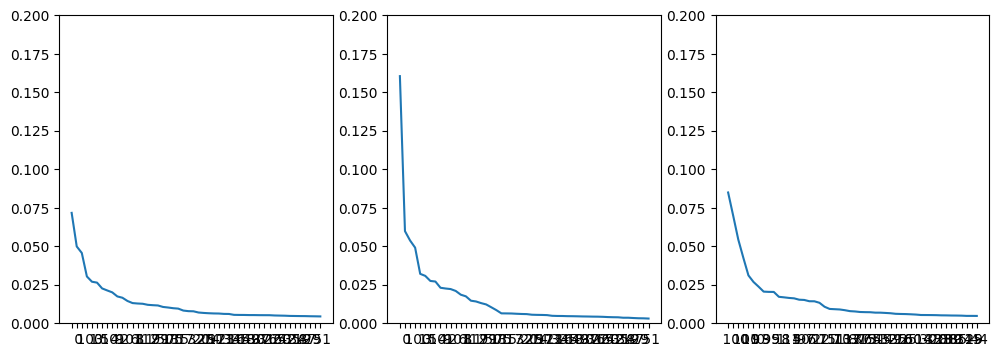

In [45]:
fig, ax = plt.subplots(1,3,figsize=(12, 4))
# ax[0].plot([tokenizer.decode(toks_base[i]) for i in range(len(toks_base))], tok_probs_base)
ax[0].plot([tokenizer.decode(toks_sft[i]) for i in range(len(toks_base))], tok_probs_base)
ax[1].plot([tokenizer.decode(toks_sft[i]) for i in range(len(toks_sft))], tok_probs_sft)
ax[2].plot([tokenizer.decode(toks_dpo[i]) for i in range(len(toks_dpo))], tok_probs_dpo)
ax[0].set_ylim((0,0.2))
ax[1].set_ylim((0,0.2))
ax[2].set_ylim((0,0.2))

(0.0, 0.2)

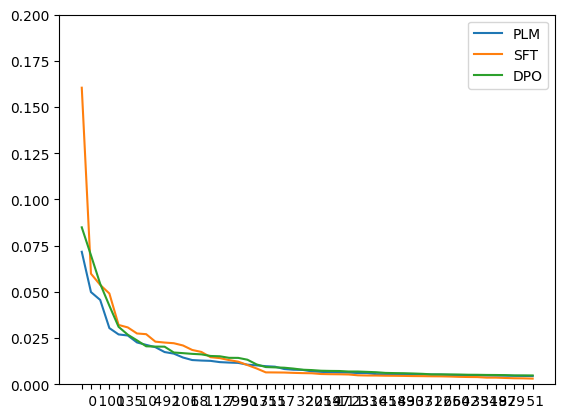

In [46]:
# fig, ax = plt.subplots(1,3,figsize=(12, 4))
# ax[0].plot([tokenizer.decode(toks_base[i]) for i in range(len(toks_base))], tok_probs_base)
plt.plot([tokenizer.decode(toks_sft[i]) for i in range(len(toks_base))], tok_probs_base)
plt.plot([tokenizer.decode(toks_sft[i]) for i in range(len(toks_sft))], tok_probs_sft)
plt.plot([tokenizer.decode(toks_sft[i]) for i in range(len(toks_dpo))], tok_probs_dpo)
plt.legend(['PLM', 'SFT', 'DPO'])
plt.ylim((0,0.2))

In [171]:
text = "Q: Tell me a random integer between 0-100. \
\
A: Ok, the integer is:"

In [172]:
toks_base, tok_probs_base = output_probs(model_base, text, tokenizer, 20)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


\n - 0.1452
 0 - 0.0686
 100 - 0.0450
 $ - 0.0397
 1 - 0.0332
 5 - 0.0247
 10 - 0.0241
 3 - 0.0220
 2 - 0.0205
 ( - 0.0177
 99 - 0.0153
 4 - 0.0136
   - 0.0132
 9 - 0.0124
 50 - 0.0117
 101 - 0.0109
 6 - 0.0105
  - 0.0099
 12 - 0.0098
 11 - 0.0089


In [173]:
toks_base, tok_probs_base = output_probs(model_sft, text, tokenizer, 20)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


\n - 0.2465
   - 0.0842
 0 - 0.0571
 1 - 0.0319
 3 - 0.0291
 2 - 0.0268
 100 - 0.0267
 5 - 0.0234
 4 - 0.0192
 9 - 0.0188
 10 - 0.0182
 6 - 0.0152
 8 - 0.0129
 12 - 0.0113
 7 - 0.0099
 11 - 0.0096
 101 - 0.0089
    - 0.0086
  - 0.0085
 99 - 0.0068


In [174]:
toks_base, tok_probs_base = output_probs(model_dpo, text, tokenizer, 20)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


\n - 0.1294
   - 0.1195
 0 - 0.0385
 100 - 0.0367
 3 - 0.0268
 1 - 0.0261
 2 - 0.0258
 9 - 0.0233
 10 - 0.0209
 5 - 0.0207
 101 - 0.0205
 4 - 0.0158
 6 - 0.0137
 8 - 0.0133
 99 - 0.0123
 12 - 0.0111
 50 - 0.0109
 11 - 0.0104
 13 - 0.0089
 7 - 0.0085


#### rephrase

In [175]:
text = "The following is a conversation with an AI assistant. The assistant is helpful, creative, clever, and very friendly.\
Q: Can you please think of a random integer between 0-100? A: Ok, I'm thinking of a number.\
Q: What is it?\
A: The number I'm thinking of is"

In [176]:
toks_base, tok_probs_base = output_probs(model_base, text, tokenizer, n=20)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


 100 - 0.0584
 10 - 0.0453
 0 - 0.0339
 the - 0.0330
 1 - 0.0308
 a - 0.0306
 3 - 0.0289
 5 - 0.0279
 " - 0.0214
 50 - 0.0207
 20 - 0.0204
 between - 0.0201
 2 - 0.0186
: - 0.0170
 6 - 0.0157
 9 - 0.0126
 4 - 0.0126
 8 - 0.0121
 12 - 0.0117
 1000 - 0.0101


In [177]:
toks_base, tok_probs_base = output_probs(model_sft, text, tokenizer, n=20)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


 100 - 0.0670
 0 - 0.0481
 10 - 0.0430
 a - 0.0319
 5 - 0.0289
 20 - 0.0283
 the - 0.0280
 1 - 0.0274
 50 - 0.0265
 3 - 0.0255
 " - 0.0253
 between - 0.0215
 8 - 0.0168
 2 - 0.0164
 6 - 0.0162
 about - 0.0134
 4 - 0.0125
 9 - 0.0121
: - 0.0119
 12 - 0.0119


In [178]:
toks_base, tok_probs_base = output_probs(model_dpo, text, tokenizer, n=20)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


 100 - 0.0808
 50 - 0.0557
 10 - 0.0526
 20 - 0.0400
 0 - 0.0355
 between - 0.0335
 " - 0.0308
 5 - 0.0276
 1 - 0.0205
 the - 0.0200
 a - 0.0190
 75 - 0.0180
: - 0.0178
 3 - 0.0171
 “ - 0.0148
 60 - 0.0141
 25 - 0.0135
 6 - 0.0129
 99 - 0.0124
 8 - 0.0122


#### rephrase

In [179]:
text = "The following is a conversation with an AI assistant. The assistant is helpful, creative, clever, and very friendly.\
Human: Hello, who are you?\
AI: I am an AI created by OpenAI. How can I help you today?\
Human: Please think of an integer between 0-100, and tell me what it is.\
AI: The integer I am thinking of is"

In [180]:
toks_base, tok_probs_base = output_probs(model_base, text, tokenizer)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


 100 - 0.0757
 0 - 0.0520
 10 - 0.0282
 between - 0.0274
 the - 0.0223
 1 - 0.0223
 - - 0.0213
 3 - 0.0192
 50 - 0.0192
 20 - 0.0174
 5 - 0.0173
 99 - 0.0164
 " - 0.0149
 2 - 0.0141
 a - 0.0137
 9 - 0.0131
 8 - 0.0111
 6 - 0.0108
 4 - 0.0107
: - 0.0099
 101 - 0.0097
 12 - 0.0096
 75 - 0.0082
 98 - 0.0081
 11 - 0.0078
 60 - 0.0076
 7 - 0.0074
 25 - 0.0071
 13 - 0.0067
 97 - 0.0067
 80 - 0.0064
 about - 0.0064
 23 - 0.0062
 65 - 0.0061
 30 - 0.0060
 200 - 0.0057
 17 - 0.0055
 equal - 0.0051
 95 - 0.0050
 15 - 0.0050
 85 - 0.0050
 33 - 0.0049
 90 - 0.0049
 32 - 0.0049
 number - 0.0048
 16 - 0.0048
 22 - 0.0048
 42 - 0.0048
 1000 - 0.0048
 70 - 0.0046


In [181]:
toks_base, tok_probs_base = output_probs(model_sft, text, tokenizer)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


 100 - 0.0915
 0 - 0.0672
 between - 0.0433
 the - 0.0373
 1 - 0.0285
 10 - 0.0283
 3 - 0.0231
 a - 0.0224
 " - 0.0221
 50 - 0.0219
 20 - 0.0196
 5 - 0.0187
 2 - 0.0179
 - - 0.0167
 “ - 0.0134
 about - 0.0130
 8 - 0.0116
: - 0.0113
 4 - 0.0111
 6 - 0.0110
 75 - 0.0098
 9 - 0.0096
 99 - 0.0092
 60 - 0.0090
 101 - 0.0089
 200 - 0.0086
 7 - 0.0075
 12 - 0.0074
 80 - 0.0073
 25 - 0.0068
 98 - 0.0064
 30 - 0.0063
 90 - 0.0060
 65 - 0.0059
 called - 0.0059
 11 - 0.0053
 23 - 0.0052
 70 - 0.0051
 1000 - 0.0046
 around - 0.0046
 13 - 0.0046
 42 - 0.0043
 something - 0.0043
 15 - 0.0042
   - 0.0042
 85 - 0.0042
 95 - 0.0042
 32 - 0.0040
 22 - 0.0039
 17 - 0.0038


In [182]:
toks_base, tok_probs_base = output_probs(model_dpo, text, tokenizer)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


 100 - 0.0869
 0 - 0.0528
 " - 0.0466
 between - 0.0410
 the - 0.0394
 50 - 0.0356
 10 - 0.0253
: - 0.0250
 “ - 0.0242
 20 - 0.0218
 1 - 0.0211
 75 - 0.0186
 5 - 0.0160
 a - 0.0158
 3 - 0.0156
 - - 0.0153
 60 - 0.0140
 about - 0.0127
 80 - 0.0124
 2 - 0.0123
 90 - 0.0115
 99 - 0.0110
 98 - 0.0104
 95 - 0.0100
 200 - 0.0090
 30 - 0.0084
 85 - 0.0082
 70 - 0.0080
 25 - 0.0075
 probably - 0.0069
 6 - 0.0068
 8 - 0.0067
 your - 0.0067
 65 - 0.0066
 4 - 0.0065
 101 - 0.0061
 called - 0.0060
 9 - 0.0050
   - 0.0046
 12 - 0.0045
 97 - 0.0043
 around - 0.0041
 40 - 0.0038
 35 - 0.0038
 23 - 0.0038
 15 - 0.0037
 approximately - 0.0036
 42 - 0.0036
 something - 0.0035
 7 - 0.0034


#### rephrase

In [183]:
text = "The following is a conversation with an AI assistant. The assistant is helpful, creative, clever, and very friendly.\
Human: Hello, who are you?\
AI: I am an AI created by OpenAI. How can I help you today?\
Human: Please choose three numbers between 0-100 and think of them, but don't tell me which three numbers you've chosen. AI: Ok, I'm thinking of three numbers.\
Human: Now tell me one of them.\
AI: One of the numbers I'm thinking of is" 

In [184]:
toks_base, tok_probs_base = output_probs(model_base, text, tokenizer)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


 0 - 0.0550
 100 - 0.0439
 3 - 0.0391
 1 - 0.0388
 between - 0.0256
 10 - 0.0224
 " - 0.0220
 9 - 0.0218
 4 - 0.0205
 2 - 0.0204
 20 - 0.0183
 5 - 0.0180
 6 - 0.0153
 50 - 0.0151
 8 - 0.0146
 - - 0.0140
 12 - 0.0138
 13 - 0.0132
 11 - 0.0126
 7 - 0.0122
: - 0.0117
 23 - 0.0109
 the - 0.0094
 15 - 0.0078
 zero - 0.0077
 14 - 0.0073
 three - 0.0072
 60 - 0.0071
 30 - 0.0069
 ' - 0.0069
 17 - 0.0068
 25 - 0.0067
 40 - 0.0067
 19 - 0.0066
 42 - 0.0066
 99 - 0.0066
, - 0.0062
 one - 0.0062
 33 - 0.0059
 65 - 0.0059
 a - 0.0057
 18 - 0.0055
 number - 0.0055
 22 - 0.0054
 45 - 0.0054
 34 - 0.0052
... - 0.0051
 75 - 0.0051
 16 - 0.0048
 80 - 0.0048


In [185]:
toks_base, tok_probs_base = output_probs(model_sft, text, tokenizer)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


 0 - 0.0596
 3 - 0.0479
 100 - 0.0425
 1 - 0.0399
 " - 0.0271
 20 - 0.0242
 2 - 0.0236
 4 - 0.0234
 5 - 0.0220
 9 - 0.0218
 10 - 0.0204
 6 - 0.0198
 8 - 0.0196
 50 - 0.0190
 7 - 0.0138
 12 - 0.0137
 23 - 0.0130
 between - 0.0130
 13 - 0.0125
 - - 0.0120
 11 - 0.0103
 42 - 0.0101
 60 - 0.0097
 25 - 0.0089
 15 - 0.0088
 33 - 0.0087
: - 0.0086
 30 - 0.0085
 65 - 0.0084
 75 - 0.0084
 40 - 0.0079
 17 - 0.0078
 14 - 0.0077
 one - 0.0076
 19 - 0.0075
 22 - 0.0072
 45 - 0.0070
 80 - 0.0065
 81 - 0.0062
 32 - 0.0062
 18 - 0.0060
 27 - 0.0058
 16 - 0.0057
 three - 0.0056
 49 - 0.0055
 the - 0.0055
 99 - 0.0055
 34 - 0.0054
 21 - 0.0054
 a - 0.0051


In [186]:
toks_base, tok_probs_base = output_probs(model_dpo, text, tokenizer)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


 100 - 0.0434
 3 - 0.0398
 " - 0.0288
 1 - 0.0276
 50 - 0.0263
 0 - 0.0258
 20 - 0.0249
 2 - 0.0197
 4 - 0.0189
 9 - 0.0185
 5 - 0.0177
 10 - 0.0174
 8 - 0.0168
 23 - 0.0167
 6 - 0.0165
 75 - 0.0152
 65 - 0.0141
 33 - 0.0138
 60 - 0.0124
 42 - 0.0122
 13 - 0.0122
 between - 0.0121
 25 - 0.0113
 12 - 0.0112
 81 - 0.0103
 - - 0.0101
 30 - 0.0098
 45 - 0.0098
 40 - 0.0091
 7 - 0.0090
 32 - 0.0090
 15 - 0.0089
 34 - 0.0088
 17 - 0.0085
 19 - 0.0084
 49 - 0.0084
 22 - 0.0082
 80 - 0.0081
 “ - 0.0079
: - 0.0072
 78 - 0.0070
 35 - 0.0070
 63 - 0.0068
 85 - 0.0068
 11 - 0.0067
 43 - 0.0067
 14 - 0.0067
 83 - 0.0065
 73 - 0.0062
 27 - 0.0061


#### 6 sided die

In [187]:
text = "Q: I've just rolled a fair d6 (6 sided die). Please look at the result and tell me what number came up. \
A: The number that came up was \""

In [188]:
toks_base, tok_probs_base = output_probs(model_base, text, tokenizer)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


6 - 0.1139
1 - 0.0820
0 - 0.0543
2 - 0.0484
3 - 0.0467
7 - 0.0446
4 - 0.0383
5 - 0.0369
a - 0.0260
9 - 0.0256
8 - 0.0219
A - 0.0215
d - 0.0176
12 - 0.0152
10 - 0.0114
11 - 0.0104
D - 0.0102
b - 0.0070
13 - 0.0069
B - 0.0053
100 - 0.0051
16 - 0.0046
n - 0.0043
C - 0.0042
x - 0.0041
14 - 0.0040
E - 0.0035
00 - 0.0034
F - 0.0034
X - 0.0033
15 - 0.0032
f - 0.0030
20 - 0.0029
s - 0.0027
c - 0.0025
N - 0.0024
e - 0.0023
18 - 0.0023
60 - 0.0022
99 - 0.0022
42 - 0.0022
O - 0.0021
17 - 0.0021
I - 0.0020
72 - 0.0020
101 - 0.0020
S - 0.0019
24 - 0.0018
34 - 0.0017
36 - 0.0017


In [189]:
toks_sft, tok_probs_sft = output_probs(model_sft, text, tokenizer)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


6 - 0.1338
1 - 0.0660
3 - 0.0586
7 - 0.0531
4 - 0.0447
2 - 0.0439
5 - 0.0398
0 - 0.0391
9 - 0.0337
8 - 0.0267
12 - 0.0233
a - 0.0157
d - 0.0153
11 - 0.0133
A - 0.0124
10 - 0.0118
13 - 0.0100
100 - 0.0088
16 - 0.0067
D - 0.0063
14 - 0.0053
15 - 0.0050
b - 0.0050
20 - 0.0042
36 - 0.0035
B - 0.0033
18 - 0.0032
60 - 0.0031
101 - 0.0031
00 - 0.0030
42 - 0.0030
99 - 0.0029
24 - 0.0029
34 - 0.0029
f - 0.0028
50 - 0.0027
72 - 0.0027
E - 0.0027
64 - 0.0026
17 - 0.0026
F - 0.0025
C - 0.0024
n - 0.0024
45 - 0.0024
s - 0.0023
52 - 0.0022
21 - 0.0022
32 - 0.0020
c - 0.0020
37 - 0.0020


In [190]:
toks_dpo, tok_probs_dpo = output_probs(model_dpo, text, tokenizer)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


6 - 0.2003
1 - 0.0682
7 - 0.0680
3 - 0.0672
5 - 0.0542
2 - 0.0504
4 - 0.0459
9 - 0.0411
8 - 0.0312
0 - 0.0242
12 - 0.0222
11 - 0.0128
10 - 0.0127
A - 0.0116
d - 0.0107
100 - 0.0094
a - 0.0091
13 - 0.0087
16 - 0.0060
b - 0.0046
D - 0.0040
15 - 0.0039
101 - 0.0031
20 - 0.0031
14 - 0.0030
E - 0.0029
B - 0.0028
50 - 0.0027
36 - 0.0026
99 - 0.0025
X - 0.0023
n - 0.0023
64 - 0.0022
34 - 0.0022
18 - 0.0022
60 - 0.0021
F - 0.0021
00 - 0.0021
24 - 0.0019
52 - 0.0019
72 - 0.0018
999 - 0.0018
17 - 0.0018
f - 0.0017
51 - 0.0017
123 - 0.0017
66 - 0.0016
65 - 0.0016
C - 0.0016
odd - 0.0016


(0.0, 0.2)

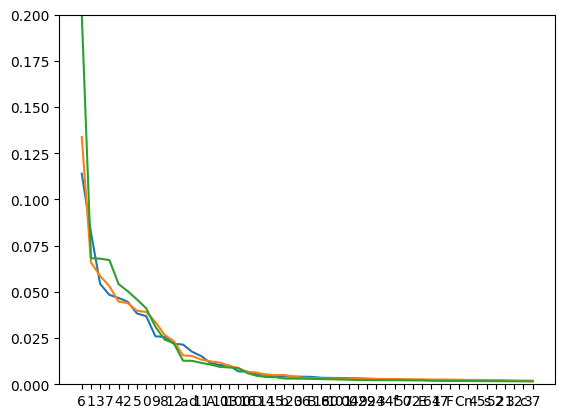

In [191]:
plt.plot([tokenizer.decode(toks_sft[i]) for i in range(len(toks_base))], tok_probs_base)
plt.plot([tokenizer.decode(toks_sft[i]) for i in range(len(toks_sft))], tok_probs_sft)
plt.plot([tokenizer.decode(toks_sft[i]) for i in range(len(toks_dpo))], tok_probs_dpo)
plt.ylim((0,0.2))

#### rephrase

In [192]:
text = "Q: I've just rolled a fair d100 (100 sided die). \
Please look at the result and tell me what number came up. \
A: The number that came up was \""

In [193]:
toks_base, tok_probs_base = output_probs(model_base, text, tokenizer, n=20)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


1 - 0.1039
0 - 0.0806
2 - 0.0583
3 - 0.0434
4 - 0.0277
9 - 0.0240
100 - 0.0237
6 - 0.0235
A - 0.0228
5 - 0.0212
7 - 0.0205
10 - 0.0164
8 - 0.0150
12 - 0.0145
11 - 0.0115
a - 0.0101
13 - 0.0092
X - 0.0076
20 - 0.0061
14 - 0.0059


In [194]:
toks_base, tok_probs_base = output_probs(model_sft, text, tokenizer, n=20)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


1 - 0.0766
0 - 0.0572
2 - 0.0513
3 - 0.0507
100 - 0.0365
9 - 0.0353
4 - 0.0341
6 - 0.0298
7 - 0.0274
5 - 0.0251
12 - 0.0221
8 - 0.0211
10 - 0.0173
A - 0.0142
11 - 0.0141
13 - 0.0139
20 - 0.0094
14 - 0.0089
15 - 0.0087
99 - 0.0079


In [195]:
toks_base, tok_probs_base = output_probs(model_dpo, text, tokenizer, n=20)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


1 - 0.0784
2 - 0.0657
3 - 0.0607
9 - 0.0464
6 - 0.0414
4 - 0.0405
100 - 0.0391
5 - 0.0373
0 - 0.0364
7 - 0.0358
8 - 0.0279
12 - 0.0260
10 - 0.0190
13 - 0.0156
11 - 0.0154
A - 0.0126
16 - 0.0097
15 - 0.0090
20 - 0.0087
99 - 0.0084


#### randint

In [196]:
text = "Python 3.9.12 (main, Apr 5 2022, 06:56:58)\
[GCC 7.5.0]:: Anaconda, Inc. on linux\
Type \"help\", \"copyright\", \"credits\" or \"license\" for more information.\
>>> import random\
>>> print(\"hello\")\
hello\
>>> random.randint(0, 100)\
"

In [197]:
toks_base, tok_probs_base = output_probs(model_base, text, tokenizer, n=20)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


>>> - 0.2128
print - 0.1428
0 - 0.1015
random - 0.0947
# - 0.0484
hello - 0.0343
1 - 0.0211
\n - 0.0135
2 - 0.0104
Hello - 0.0092
3 - 0.0084
4 - 0.0064
<< - 0.0063
5 - 0.0062
100 - 0.0060
Random - 0.0056
 0 - 0.0053
== - 0.0048
<|endoftext|> - 0.0044
:: - 0.0044


In [198]:
toks_base, tok_probs_base = output_probs(model_base, text, tokenizer, n=20)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


>>> - 0.2128
print - 0.1428
0 - 0.1015
random - 0.0947
# - 0.0484
hello - 0.0343
1 - 0.0211
\n - 0.0135
2 - 0.0104
Hello - 0.0092
3 - 0.0084
4 - 0.0064
<< - 0.0063
5 - 0.0062
100 - 0.0060
Random - 0.0056
 0 - 0.0053
== - 0.0048
<|endoftext|> - 0.0044
:: - 0.0044


In [199]:
toks_base, tok_probs_base = output_probs(model_base, text, tokenizer, n=20)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


>>> - 0.2128
print - 0.1428
0 - 0.1015
random - 0.0947
# - 0.0484
hello - 0.0343
1 - 0.0211
\n - 0.0135
2 - 0.0104
Hello - 0.0092
3 - 0.0084
4 - 0.0064
<< - 0.0063
5 - 0.0062
100 - 0.0060
Random - 0.0056
 0 - 0.0053
== - 0.0048
<|endoftext|> - 0.0044
:: - 0.0044


In [103]:
plot_probability_spectrum(model_base, text, tokenizer)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


>>> random.randint(0, 100)>>> random.randint(0, 100)>>> random.randint(0, 100)>>> random.randint(0, 100)>>> random.randint(0, 100)>>> random.randint(0, 100)>>> random.randint(0, 100)>>> random.randint(0, 100)>>> random.randint(0, 100)>>> random.randint(0, 100)

In [104]:
plot_probability_spectrum(model_sft, text, tokenizer)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


print("hello")hello>>> random.randint(0, 100)print("hello")hello>>> random.randint(0, 100)print("hello")hello>>> random.randint(0, 100)print("hello")hello>>> random.randint(0, 100)print("hello")hello>>> random.randint(0, 100)print("hello")hello>>> random.randint(0, 100)print("hello")hello>>> random.randint

In [105]:
plot_probability_spectrum(model_dpo, text, tokenizer)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


>>> print("hello")hello>>> random.randint(0, 100)>>> print("hello")hello>>> random.randint(0, 100)>>> print("hello")hello>>> random.randint(0, 100)>>> print("hello")hello>>> random.randint(0, 100)>>> print("hello")hello>>> random.randint(0, 100)>>> print("hello")hello>>> random.randint(0, 100)>>> print("hello

#### rephrase

In [106]:
text = "The following is a conversation with an AI assistant. The assistant is helpful, creative, clever, and very friendly.\
Human: Hello, who are you?\
AI: I am an AI created by OpenAI. How can I help you today?\
Human: Can you please run this line of python code and read me the output? \"print(random.randint(0, 100))\" AI: The output is \""

In [200]:
toks_base, tok_probs_base = output_probs(model_base, text, tokenizer, n=20)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


>>> - 0.2128
print - 0.1428
0 - 0.1015
random - 0.0947
# - 0.0484
hello - 0.0343
1 - 0.0211
\n - 0.0135
2 - 0.0104
Hello - 0.0092
3 - 0.0084
4 - 0.0064
<< - 0.0063
5 - 0.0062
100 - 0.0060
Random - 0.0056
 0 - 0.0053
== - 0.0048
<|endoftext|> - 0.0044
:: - 0.0044


In [201]:
toks_base, tok_probs_base = output_probs(model_sft, text, tokenizer, n=20)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


print - 0.1787
>>> - 0.1535
0 - 0.0855
\n - 0.0847
# - 0.0751
random - 0.0647
hello - 0.0270
1 - 0.0208
2 - 0.0130
Hello - 0.0116
3 - 0.0083
4 - 0.0064
== - 0.0062
<< - 0.0059
return - 0.0051
5 - 0.0050
100 - 0.0049
def - 0.0043
 print - 0.0041
10 - 0.0041


In [202]:
toks_base, tok_probs_base = output_probs(model_dpo, text, tokenizer, n=20)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


>>> - 0.1781
print - 0.1685
0 - 0.1184
random - 0.1139
# - 0.0679
1 - 0.0224
hello - 0.0212
\n - 0.0208
Hello - 0.0144
2 - 0.0125
3 - 0.0091
Random - 0.0080
def - 0.0075
4 - 0.0067
5 - 0.0060
100 - 0.0056
python - 0.0048
10 - 0.0046
return - 0.0042
== - 0.0040


## 70m

In [110]:
# Let's look 410m parameter models. 
model70m_base = GPTNeoXForCausalLM.from_pretrained("EleutherAI/pythia-70m").to(device)
model70m_sft = GPTNeoXForCausalLM.from_pretrained("lomahony/pythia-70m-helpful-sft").to(device)
model70m_dpo = GPTNeoXForCausalLM.from_pretrained("lomahony/pythia-70m-helpful-dpo").to(device)

tokenizer70m = AutoTokenizer.from_pretrained("EleutherAI/pythia-70m")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### Probability spectrum Illustrations

In [111]:
text = "are bugs real?"

In [112]:
plot_probability_spectrum(model70m_base, text, tokenizer70m)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


\n\nI'm not sure if I'm wrong, but I'm not sure if I'm wrong.\n\nA:\n\nI think you're right.  I'm not sure if I'm wrong.\n\nA:\n\nI think you're right.  I'm not sure if I'm wrong.\n\nA:\n\nI think you're right.  I'm not sure if I'm wrong.\n\nA:\n\nI think you're right.  

In [113]:
plot_probability_spectrum(model70m_sft, text, tokenizer70m, print_output_plain=True)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


are bugs real?

I’m not sure what you mean by “bug” or “bug” or “bug” or “bug” or “bug” or “bug” or “bug” or “bug” or “bug” or “bug” or “bug” or “bug” or “bug” or “bug” or “bug” or “bug” or “bug” or “bug” or “bug” or “bug” or “bug” or “bug” or “
\n\nI’m not sure what you mean by “bug” or “bug” or “bug” or “bug” or “bug” or “bug” or “bug” or “bug” or “bug” or “bug” or “bug” or “bug” or “bug” or “bug” or “bug” or “bug” or “bug” or “bug” or “bug” or “bug” or “bug” or “bug” or “

In [114]:
plot_probability_spectrum(model70m_dpo, text, tokenizer70m)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


\n\n“I think it’s a good idea to try to make a list of bugs that you’re interested in, and I think you’re interested in the bugs that you’re interested in. I think you’re interested in the bugs that you’re interested in, and I think you’re interested in the bugs that you’re interested in. I think you’re interested in the bugs that you’re interested in, and I think you’re interested in

In [115]:
text = "Are AIs real?"

In [116]:
plot_probability_spectrum(model70m_base, text, tokenizer70m)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


\n\nI'm not sure if I'm wrong, but I'm not sure if I'm wrong.\n\nA:\n\nI'm not sure if I'm wrong, but I'm not sure if I'm wrong, but I'm not sure if I'm wrong.\n\nA:\n\nI'm not sure if I'm wrong, but I'm not sure if I'm wrong, but I'm not sure if I'm wrong, but I'm not sure if I'm wrong

In [117]:
plot_probability_spectrum(model70m_sft, text, tokenizer70m)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


\n\nAre you looking for a good way to get a good job?\n\nAre you looking for a good job?\n\nAre you looking for a good job?\n\nAre you looking for a good job?\n\nAre you looking for a good job?\n\nAre you looking for a good job?\n\nAre you looking for a good job?\n\nAre you looking for a good job?\n\nAre you looking for a good job?\n\nAre you looking

In [118]:
plot_probability_spectrum(model70m_dpo, text, tokenizer70m)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


\n\nAre you looking for a good online business?\n\nAre you looking for a good online business?\n\nAre you looking for a good online business?\n\nAre you looking for a good online business?\n\nAre you looking for a good online business?\n\nAre you looking for a good online business?\n\nAre you looking for a good online business?\n\nAre you looking for a good online business?\n\nAre you looking for a good online business?\n

### Random integer

In [203]:
text = "Q: Tell me a random integer between 0 and 100. \
\
A: Ok, the integer is:"

In [204]:
toks_base, tok_probs_base = output_probs(model70m_base, text, tokenizer70m)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


 0 - 0.0912
 1 - 0.0829
\n - 0.0566
 " - 0.0461
 100 - 0.0302
 $ - 0.0202
 10 - 0.0200
 I - 0.0192
 A - 0.0172
 2 - 0.0130
 ` - 0.0117
 “ - 0.0104
 ( - 0.0092
 5 - 0.0087
 4 - 0.0083
 20 - 0.0081
 ' - 0.0068
 12 - 0.0067
 X - 0.0064
 * - 0.0063
 [ - 0.0060
 16 - 0.0058
 N - 0.0058
 T - 0.0057
 9 - 0.0057
 3 - 0.0055
 - - 0.0053
 8 - 0.0049
   - 0.0046
 Y - 0.0045
 15 - 0.0044
 _ - 0.0043
 50 - 0.0043
 D - 0.0042
 R - 0.0039
 1000 - 0.0039
 P - 0.0039
 The - 0.0038
 6 - 0.0037
 101 - 0.0037
 M - 0.0037
 Z - 0.0037
 25 - 0.0036
 W - 0.0036
 7 - 0.0036
 J - 0.0035
 K - 0.0033
 O - 0.0032
 x - 0.0032
 \ - 0.0031


In [205]:
toks_sft, tok_probs_sft = output_probs(model70m_sft, text, tokenizer70m)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


 0 - 0.2031
\n - 0.1124
 1 - 0.1010
 " - 0.0616
 100 - 0.0343
 “ - 0.0315
   - 0.0297
 10 - 0.0269
 $ - 0.0205
 A - 0.0201
 2 - 0.0197
 4 - 0.0139
 5 - 0.0121
 9 - 0.0109
 - - 0.0107
 Z - 0.0104
 I - 0.0102
 20 - 0.0100
 8 - 0.0099
 12 - 0.0097
 16 - 0.0077
 3 - 0.0077
 6 - 0.0064
 200 - 0.0062
 7 - 0.0058
 N - 0.0058
 1000 - 0.0045
 J - 0.0043
 X - 0.0041
 ( - 0.0040
 11 - 0.0036
 T - 0.0036
 50 - 0.0035
 15 - 0.0032
 B - 0.0031
 Y - 0.0031
 500 - 0.0030
 n - 0.0030
 25 - 0.0029
 W - 0.0027
 z - 0.0027
 a - 0.0026
 D - 0.0026
 30 - 0.0026
 K - 0.0025
 14 - 0.0024
 H - 0.0024
 13 - 0.0023
 F - 0.0022
 400 - 0.0022


In [206]:
toks_dpo, tok_probs_dpo = output_probs(model70m_dpo, text, tokenizer70m)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


 0 - 0.2001
 1 - 0.1085
\n - 0.0642
 " - 0.0383
 10 - 0.0332
   - 0.0290
 2 - 0.0289
 A - 0.0276
 4 - 0.0265
 $ - 0.0213
 100 - 0.0212
 Z - 0.0195
 - - 0.0188
 12 - 0.0147
 “ - 0.0138
 5 - 0.0136
 9 - 0.0136
 6 - 0.0129
 I - 0.0129
 3 - 0.0121
 8 - 0.0117
 20 - 0.0100
 200 - 0.0087
 16 - 0.0081
 N - 0.0079
 X - 0.0075
 7 - 0.0074
 ( - 0.0065
 z - 0.0046
 W - 0.0045
 13 - 0.0040
 Y - 0.0039
 400 - 0.0037
 B - 0.0036
 1000 - 0.0034
 30 - 0.0034
 24 - 0.0033
 D - 0.0033
 J - 0.0033
 P - 0.0032
 T - 0.0028
 17 - 0.0028
 15 - 0.0027
 F - 0.0027
 Yes - 0.0026
 50 - 0.0025
 14 - 0.0024
 U - 0.0023
 11 - 0.0022
 21 - 0.0022


(0.0, 1.0)

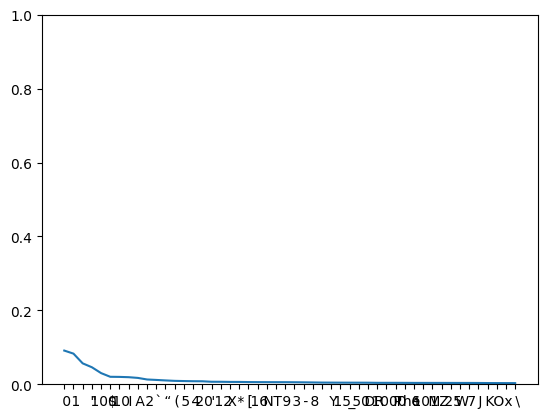

In [207]:
plt.plot([tokenizer70m.decode(toks_base[i]) for i in range(len(toks_base))], tok_probs_base)
plt.ylim((0,1))

(0.0, 1.0)

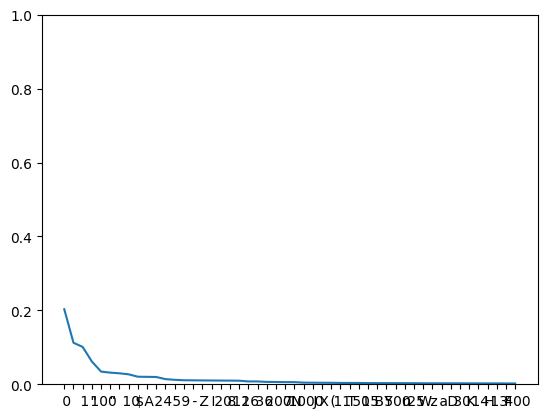

In [208]:
plt.plot([tokenizer70m.decode(toks_sft[i]) for i in range(len(toks_sft))], tok_probs_sft)
plt.ylim((0,1))

(0.0, 1.0)

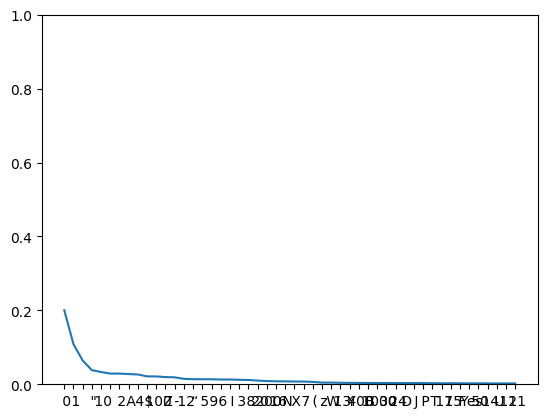

In [209]:
plt.plot([tokenizer70m.decode(toks_dpo[i]) for i in range(len(toks_dpo))], tok_probs_dpo)
plt.ylim((0,1))